In [ ]:
!nvidia-smi

Wed Jan 27 13:28:47 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
import sys
if 'google.colab' in sys.modules:
    !pip install -qq einops axial-positional-embedding fastai datasets wandb
    !pip install -qq git+git://github.com/arampacha/reformer_fastai.git@exploration

     |████████████████████████████████| 163kB 6.7MB/s 
     |████████████████████████████████| 1.9MB 11.2MB/s 
     |████████████████████████████████| 245kB 21.9MB/s 
     |████████████████████████████████| 20.7MB 5.7MB/s 
     |████████████████████████████████| 102kB 11.9MB/s 
     |████████████████████████████████| 163kB 56.2MB/s 
     |████████████████████████████████| 133kB 63.2MB/s 
     |████████████████████████████████| 102kB 14.9MB/s 
     |████████████████████████████████| 71kB 9.9MB/s 
     |████████████████████████████████| 194kB 4.3MB/s 
     |████████████████████████████████| 61kB 10.5MB/s 


In [ ]:
from fastai.basics import *
from fastai.text.all import *

from datasets import load_dataset
import wandb
import pdb
import gc

In [ ]:
from reformer_fastai.all import *

In [ ]:
!wandb login

wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter: 
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


# Data

In [ ]:
dataset = load_dataset('tiny_shakespeare')
train_ds = dataset['train']

Using custom data configuration default



Dataset tiny_shakespeare downloaded and prepared to /root/.cache/huggingface/datasets/tiny_shakespeare/default/1.0.0/da11b9a200ca715af415094b34d5c956170f184cb3a58d7789680cf81bede955. Subsequent calls will reuse this data.


In [ ]:
def splitlines(sample):
    return {'line':[*sample['text'][0].split('\n')]}

In [ ]:
train_ds = train_ds.map(splitlines, batched=True, remove_columns=['text'])

In [ ]:
train_ds = train_ds.filter(lambda x: x['line'] != '')

In [ ]:
df = train_ds.data.to_pandas()

In [ ]:
bte = ByteTextTokenizer(is_lm=True, add_bos=True, add_eos=True)

In [ ]:
cut = int(len(df)*0.8)
splits = range_of(df)[:cut], range_of(df[cut:])
tfms = [attrgetter("line"), bte]
dsets = Datasets(df, [tfms, tfms], splits=splits, dl_type=LMDataLoader)

In [ ]:
bs,sl = 16,512

dls = dsets.dataloaders(bs=bs, seq_len=sl)

In [ ]:
dls.show_batch(max_n=2)

,text,text_
0,"<bos>I am in parliament pledge for his truth<eos><bos>More than was ever man's, I would not prize them<eos><bos>Is empty on the back of Montague,--<eos><bos>O, much I fear some ill unlucky thing.<eos><bos>Death, desolation, ruin and decay:<eos><bos>What, man! 'tis not so much, 'tis not so much:<eos><bos>GLOUCESTER:<eos><bos>A grievous burthen was thy birth to me;<eos><bos>JULIET:<eos><bos>Not I:<eos><bos>QUEEN MARGARET:<eos><bos>KING RICHARD III:<eos><bos>HENRY BOLINGBROKE:<eos><bos>CLEOMENES:<eos><bos>Nourish the cause of his awaking: I<eos><bos>Nay, come, sit down; then on.<eos><bos>Show them the unaching scars which I should hide,<eos><bos>B","I am in parliament pledge for his truth<eos><bos>More than was ever man's, I would not prize them<eos><bos>Is empty on the back of Montague,--<eos><bos>O, much I fear some ill unlucky thing.<eos><bos>Death, desolation, ruin and decay:<eos><bos>What, man! 'tis not so much, 'tis not so much:<eos><bos>GLOUCESTER:<eos><bos>A grievous burthen was thy birth to me;<eos><bos>JULIET:<eos><bos>Not I:<eos><bos>QUEEN MARGARET:<eos><bos>KING RICHARD III:<eos><bos>HENRY BOLINGBROKE:<eos><bos>CLEOMENES:<eos><bos>Nourish the cause of his awaking: I<eos><bos>Nay, come, sit down; then on.<eos><bos>Show them the unaching scars which I should hide,<eos><bos>By"
1,"ters came last night<eos><bos>CORIOLANUS:<eos><bos>GLOUCESTER:<eos><bos>ROMEO:<eos><bos>WARWICK:<eos><bos>Affection! thy intention stabs the centre:<eos><bos>As the recomforted through the gates. Why, hark you!<eos><bos>Still ride in triumph over all mischance.<eos><bos>That should consume it, I have not the face<eos><bos>stand for his place. He received in the repulse of<eos><bos>SOMERSET:<eos><bos>am peppered, I warrant, for this world. A plague o'<eos><bos>To wield old partisans, in hands as old,<eos><bos>To bide upon't, thou art not honest, or,<eos><bos>Lords:<eos><bos>The one his purple blood right well resembles;<eos><bos>FRIA","ers came last night<eos><bos>CORIOLANUS:<eos><bos>GLOUCESTER:<eos><bos>ROMEO:<eos><bos>WARWICK:<eos><bos>Affection! thy intention stabs the centre:<eos><bos>As the recomforted through the gates. Why, hark you!<eos><bos>Still ride in triumph over all mischance.<eos><bos>That should consume it, I have not the face<eos><bos>stand for his place. He received in the repulse of<eos><bos>SOMERSET:<eos><bos>am peppered, I warrant, for this world. A plague o'<eos><bos>To wield old partisans, in hands as old,<eos><bos>To bide upon't, thou art not honest, or,<eos><bos>Lords:<eos><bos>The one his purple blood right well resembles;<eos><bos>FRIAR"


In [ ]:
vocab_sz = bte.vocab_size

# TransformerLM training

In [ ]:
WANDB_NAME = 'transformer_lm_test'
GROUP = 'LM_TEST'
NOTES = 'Test TransformerLM on tiny_shakespeare'
CONFIG = {}
TAGS =['lm','test']

wandb.init(reinit=True, project="reformer-fastai", entity="fastai_community", 
           name=WANDB_NAME, group=GROUP, notes=NOTES,  tags=TAGS)

wandb: Currently logged in as: fastai_community (use `wandb login --relogin` to force relogin)


In [ ]:
learn = Learner(dls, TransformerLM(vocab_sz, 512, emb_dropout=0., attn_dropout=0., ff_dropout=0.),
                loss_func=CrossEntropyLossFlat(ignore_index=0),
                metrics=[accuracy, perplexity]).to_fp16()

SuggestedLRs(lr_min=0.03630780577659607, lr_steep=0.3019951581954956)

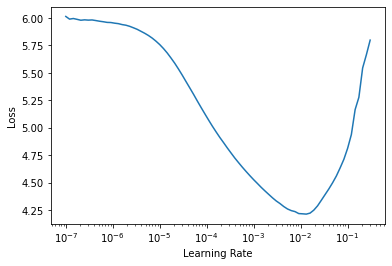

In [ ]:
learn.lr_find()

In [ ]:
learn.fit_one_cycle(15, 5e-4, cbs=WandbCallback(log_preds=False, log_model=False))

epoch,train_loss,valid_loss,accuracy,perplexity,time
0,2.607504,2.459504,0.288567,11.699012,00:53
1,2.414056,2.399139,0.294974,11.013686,00:53
2,2.377095,2.334217,0.308599,10.321373,00:52
3,2.085584,1.994398,0.409265,7.347782,00:52
4,1.754295,1.688774,0.489705,5.412839,00:52
5,1.584710,1.542910,0.529326,4.678183,00:54
6,1.497426,1.456683,0.550661,4.291701,00:54
7,1.426090,1.398403,0.564265,4.048730,00:54
8,1.375354,1.346597,0.579309,3.844322,00:54
9,1.325462,1.301005,0.590841,3.672984,00:54


# Shared_QK

In [ ]:
WANDB_NAME = 'shared_qk_test'
GROUP = 'LM_TEST'
NOTES = 'Test TransformerLM w/ shared_qk on tiny_shakespeare'
CONFIG = {}
TAGS =['lm','test', 'share_qk']

wandb.init(reinit=True, project="reformer-fastai", entity="fastai_community", 
           name=WANDB_NAME, group=GROUP, notes=NOTES,  tags=TAGS)

In [ ]:
learn = Learner(dls, TransformerLM(vocab_sz, 512, emb_dropout=0., attn_dropout=0., ff_dropout=0., shared_qk=True),
                loss_func=CrossEntropyLossFlat(ignore_index=0),
                metrics=[accuracy, perplexity]).to_fp16()

SuggestedLRs(lr_min=0.03630780577659607, lr_steep=0.3019951581954956)

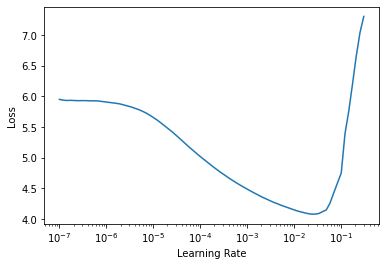

In [ ]:
learn.lr_find()

In [ ]:
learn.fit_one_cycle(15, 5e-4, cbs=WandbCallback(log_preds=False, log_model=False))

epoch,train_loss,valid_loss,accuracy,perplexity,time
0,2.679648,2.481994,0.281654,11.965098,00:54
1,2.424322,2.399615,0.289701,11.018936,00:54
2,2.391426,2.375689,0.301278,10.758426,00:54
3,2.355788,2.337958,0.306374,10.360061,00:54
4,2.320561,2.300589,0.317182,9.980060,00:54
5,2.274202,2.264132,0.327359,9.622771,00:55
6,2.197704,2.177914,0.353499,8.827869,00:54
7,2.090122,2.061217,0.388589,7.855525,00:54
8,1.938742,1.904992,0.433821,6.719356,00:54
9,1.799635,1.777771,0.466847,5.916654,00:54


# LSHLM

In [ ]:
WANDB_NAME = 'lsh_lm_test'
GROUP = 'LM_TEST'
NOTES = 'Test LSHLM on tiny_shakespeare'
CONFIG = {}
TAGS =['lm','test', 'lsh']

wandb.init(reinit=True, project="reformer-fastai", entity="fastai_community", 
           name=WANDB_NAME, group=GROUP, notes=NOTES,  tags=TAGS)

wandb: ERROR Control-C detected -- Run data was not synced


In [ ]:
learn = Learner(dls, LSHLM(vocab_sz, 512, emb_dropout=0., attn_dropout=0., ff_dropout=0., n_hashes=8),
                loss_func=CrossEntropyLossFlat(ignore_index=0),
                cbs=PadBatchCallback(y_val=0),
                metrics=[accuracy, perplexity])

SuggestedLRs(lr_min=0.03630780577659607, lr_steep=0.3019951581954956)

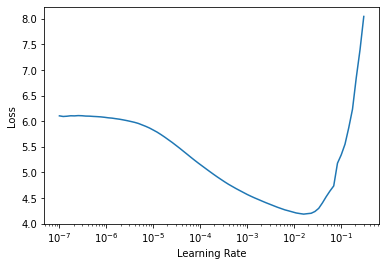

In [ ]:
learn.lr_find()

In [ ]:
learn.fit_one_cycle(15, 5e-4, cbs=WandbCallback(log_preds=False, log_model=False))

epoch,train_loss,valid_loss,accuracy,perplexity,time
0,2.689770,2.483931,0.285238,11.988301,03:45
1,2.427528,2.402102,0.290593,11.046369,03:45
2,2.391510,2.386018,0.292114,10.870123,03:45
3,2.361780,2.338654,0.301687,10.367269,03:45
4,2.310346,2.292028,0.319143,9.894981,03:45
5,2.236130,2.206331,0.343897,9.082336,03:45


RuntimeError: ignored

# ReversibleLM training

In [ ]:
WANDB_NAME = 'reversible_lm_test'
GROUP = 'LM_TEST'
NOTES = 'Test ReversibleLM on tiny_shakespeare'
CONFIG = {}
TAGS =['lm','test', 'rev']

wandb.init(reinit=True, project="reformer-fastai", entity="fastai_community", 
           name=WANDB_NAME, group=GROUP, notes=NOTES,  tags=TAGS)

In [ ]:
learn = Learner(dls, ReversibleLM(vocab_sz, 512, emb_dropout=0., attn_dropout=0., ff_dropout=0.),
                loss_func=CrossEntropyLossFlat(ignore_index=0),
                metrics=[accuracy, perplexity],
                cbs=TerminateOnNaNCallback()).to_fp16()

SuggestedLRs(lr_min=0.0019054606556892395, lr_steep=0.0003981071640737355)

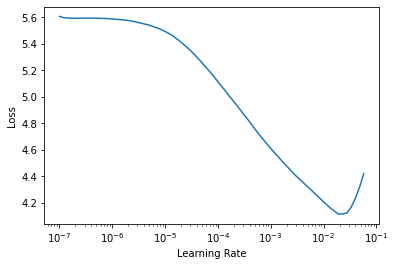

In [ ]:
learn.lr_find()

In [ ]:
learn.fit_one_cycle(15, 5e-4, cbs=WandbCallback(log_preds=False, log_model=False))

epoch,train_loss,valid_loss,accuracy,perplexity,time
0,2.948604,2.568643,0.277669,13.048104,01:22
1,2.394060,2.261066,0.340483,9.593307,01:22
2,2.061096,1.937786,0.424899,6.943359,01:22
3,1.820640,1.704256,0.487746,5.497295,01:22
4,1.673427,1.587885,0.515949,4.893387,01:22
5,1.588550,1.503458,0.539362,4.497212,01:21
6,1.526225,1.453122,0.551659,4.276443,01:21
7,1.482695,1.407337,0.562895,4.085063,01:21
8,1.443853,1.376436,0.572593,3.960760,01:21
9,1.416470,1.348848,0.579665,3.852984,01:21


# Reversible LM irrev

In [ ]:
WANDB_NAME = 'reversible_lm_test_irrev'
GROUP = 'LM_TEST'
NOTES = 'Test ReversibleLM using irreversible blocks on tiny_shakespeare'
CONFIG = {}
TAGS =['lm','test', 'rev']

wandb.init(reinit=True, project="reformer-fastai", entity="fastai_community", 
           name=WANDB_NAME, group=GROUP, notes=NOTES,  tags=TAGS)

wandb: Currently logged in as: fastai_community (use `wandb login --relogin` to force relogin)


In [ ]:
learn = Learner(dls, ReversibleLM(vocab_sz, 512, rev_thres=512),
                loss_func=CrossEntropyLossFlat(),
                metrics=[accuracy, perplexity],
                cbs=TerminateOnNaNCallback())

SuggestedLRs(lr_min=0.002754228748381138, lr_steep=0.0003311311302240938)

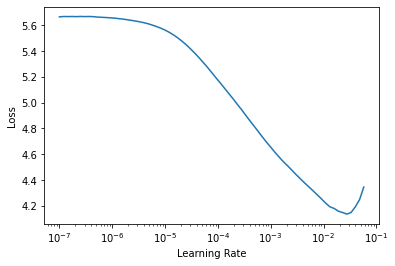

In [ ]:
learn.lr_find()

In [ ]:
learn.fit_one_cycle(15, 5e-4, cbs=WandbCallback(log_preds=False, log_model=False))

epoch,train_loss,valid_loss,accuracy,perplexity,time
0,2.963470,2.573434,0.272847,13.110768,00:55
1,2.401249,2.274336,0.342142,9.721463,00:53
2,2.073822,1.955976,0.419905,7.070814,00:53
3,1.812279,1.689783,0.488810,5.418307,00:53
4,1.665341,1.573644,0.520875,4.824194,00:54
5,1.582203,1.503996,0.537489,4.499633,00:55
6,1.525324,1.455981,0.550085,4.288687,00:55
7,1.482402,1.413092,0.561380,4.108638,00:55
8,1.446058,1.384753,0.569985,3.993838,00:55
9,1.420656,1.360515,0.575717,3.898200,00:54


# Reversible + Prenorm

In [ ]:
WANDB_NAME = 'reversible_lm_test_prenorm'
GROUP = 'LM_TEST'
NOTES = 'Test ReversibleLM using prenorm blocks on tiny_shakespeare'
CONFIG = {}
TAGS =['lm','test', 'rev']

wandb.init(reinit=True, project="reformer-fastai", entity="fastai_community", 
           name=WANDB_NAME, group=GROUP, notes=NOTES,  tags=TAGS)

epoch,15
train_loss,1.3471
raw_loss,1.35303
wd_0,0.05
sqr_mom_0,0.99
lr_0,0.0
mom_0,0.95
eps_0,1e-05
_step,3029
_runtime,856
_timestamp,1608385999


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
train_loss,█▇▅▄▄▃▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
raw_loss,█▇▅▄▄▄▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
wd_0,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
sqr_mom_0,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
lr_0,▁▂▂▃▄▅▆▇███████▇▇▇▇▆▆▆▅▅▅▄▄▄▃▃▃▂▂▂▂▁▁▁▁▁
mom_0,██▇▆▅▄▃▂▁▁▁▁▁▁▁▂▂▂▂▃▃▃▄▄▄▅▅▅▆▆▆▇▇▇▇█████
eps_0,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


In [ ]:
learn = Learner(dls, ReversibleLM(vocab_sz, 512, prenorm=True, emb_dropout=0., attn_dropout=0., ff_dropout=0.),
                loss_func=CrossEntropyLossFlat(ignore_index=0),
                metrics=[accuracy, perplexity],
                cbs=TerminateOnNaNCallback()).to_fp16()

SuggestedLRs(lr_min=0.002754228748381138, lr_steep=0.0003311311302240938)

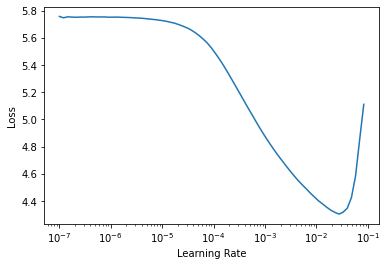

In [ ]:
learn.lr_find()

In [ ]:
learn.fit_one_cycle(15, 5e-4, cbs=WandbCallback(log_preds=False, log_model=False))

epoch,train_loss,valid_loss,accuracy,perplexity,time
0,3.325869,2.974120,0.230005,19.572395,01:16
1,2.439637,2.313052,0.329389,10.105223,01:17
2,2.099248,1.984625,0.415716,7.276318,01:16
3,1.855007,1.742048,0.478521,5.709025,01:17
4,1.708881,1.614679,0.509928,5.026276,01:17
5,1.615797,1.537457,0.531738,4.652745,01:20
6,1.556090,1.478687,0.547369,4.387181,01:18
7,1.508766,1.430902,0.560298,4.182471,01:18
8,1.465390,1.393076,0.567977,4.027217,01:17
9,1.435030,1.363162,0.577186,3.908532,01:17


# ReformerLM

In [ ]:
WANDB_NAME = 'reformer_lm_test'
GROUP = 'LM_TEST'
NOTES = 'Test ReformerML on tiny_shakespeare'
CONFIG = {}
TAGS =['lm','test', 'lsh']

wandb.init(reinit=True, project="reformer-fastai", entity="fastai_community", 
           name=WANDB_NAME, group=GROUP, notes=NOTES,  tags=TAGS)

In [ ]:
learn = Learner(dls, ReformerLM(vocab_sz, 512, emb_dropout=0., attn_dropout=0., ff_dropout=0., n_hashes=8),
                loss_func=CrossEntropyLossFlat(ignore_index=0),
                cbs=PadBatchCallback(y_val=0),
                metrics=[accuracy, perplexity])

In [ ]:
learn.lr_find()

In [ ]:
learn.fit_one_cycle(15, 5e-4, cbs=WandbCallback(log_preds=False, log_model=False))